# Import and setup

In [9]:
import os
import random
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# Librerie personalizzate
from dataset import BloodCellDataset
from model import CustomModel
from train import train_one_epoch, validate
from utils import plot_confusion_matrix, plot_normalized_confusion_matrix

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

 # Parameters

In [11]:
DATASET_PATH = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\PKG-AML-Cytomorphology_LMU"
VALID_FOLDERS = ["NGS","LYT","MON","MYO"]
IMG_SIZE = 400

TEST_RATIO = 0.1  # 10% test esterno
N_FOLDS = 5
SEED = 42

BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
MODEL_NAME = "resnet18"
PRETRAINED = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


# Dataset Creation

In [12]:
full_dataset = BloodCellDataset(
    root_dir=DATASET_PATH,
    valid_folders=VALID_FOLDERS,
    img_size=IMG_SIZE,
    transform=None  # None, così tutti i dati sono "puliti"
)

all_labels = np.array(full_dataset.labels)
all_indices = np.arange(len(full_dataset))


# Separazione 10% come final test set

In [13]:
class_to_indices = {}
for idx, label in enumerate(all_labels):
    class_to_indices.setdefault(label, []).append(idx)

test_indices = []
trainval_indices = []

for label, idx_list in class_to_indices.items():
    idx_arr = np.array(idx_list)
    np.random.shuffle(idx_arr)
    n_test = int(len(idx_arr)*TEST_RATIO)

    test_part = idx_arr[:n_test]
    train_part = idx_arr[n_test:]

    test_indices.extend(test_part)
    trainval_indices.extend(train_part)

test_indices = np.array(test_indices)
trainval_indices = np.array(trainval_indices)

print(f"Test set esterno: {len(test_indices)} esempi")
print(f"Train+Val set (K-fold): {len(trainval_indices)} esempi")

# Creiamo Subset "puro" per test esterno
final_test_dataset = Subset(full_dataset, test_indices)

Test set esterno: 1745 esempi
Train+Val set (K-fold): 15733 esempi


# K-FOLD

In [14]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
labels_for_90 = all_labels[trainval_indices]

# Data augmentation per train
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=180, p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Transform di base per val/test
val_transform = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Per la WeightedRandomSampler, calcoliamo le class weights
# 1 / freq_di_classe = peso. (Es. meno frequente = peso maggiore)
unique_labels, counts = np.unique(labels_for_90, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

# Ad es. weight[class] = 1/count
max_count = max(class_counts.values())
weight_per_class = {}
for c, cnt in class_counts.items():
    weight_per_class[c] = max_count / cnt  # un modo per "bilanciare"

def make_sampler(indices_array):
    # Ritorna un WeightedRandomSampler per oversampling
    # in base a weight_per_class.
    sample_weights = []
    for idx in indices_array:
        label = all_labels[idx]
        sample_weights.append(weight_per_class[label])
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(indices_array),  # parità con dimensione set
        replacement=True  # sampling con rimpiazzo
    )
    return sampler

# Funzione per creare un dataset con transform
class SubsetAlbumentations(Dataset):
    def __init__(self, base_dataset, indices, albumentations_transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = albumentations_transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        real_idx = self.indices[i]
        img, label = self.base_dataset[real_idx]
        # Se dataset ritorna un np array HxWxC o un Tensor CxHxW...
        # Adattiamo per Albumentations
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1,2,0).numpy()
        else:
            img_np = img
        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented["image"]
        return img, label

fold_accuracies = []
fold_number = 1

# K FOLD EXEC

In [27]:
for train_idx, val_idx in skf.split(trainval_indices, labels_for_90):
    print(f"\n=== Fold {fold_number}/{N_FOLDS} ===")
    real_train_indices = trainval_indices[train_idx]
    real_val_indices   = trainval_indices[val_idx]

    print("Train set fold:", len(real_train_indices), "| Val set fold:", len(real_val_indices))

    ds_train = SubsetAlbumentations(full_dataset, real_train_indices, albumentations_transform=train_transform)
    ds_val   = SubsetAlbumentations(full_dataset, real_val_indices, albumentations_transform=val_transform)

    sampler_train = make_sampler(real_train_indices)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler_train, num_workers=0)
    dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = CustomModel(
        num_classes=full_dataset.num_classes,
        model_name=MODEL_NAME,
        pretrained=PRETRAINED
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        print(f"  Epoch {epoch+1}/{EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, dl_train, criterion, optimizer, DEVICE)
        val_loss, val_acc, precision, recall, f1, preds, labels = validate(model, dl_val, criterion, DEVICE)

        print(f"    TrainLoss: {train_loss:.4f}  Acc: {train_acc:.4f}"
              f" | ValLoss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        # --- SALVATAGGIO DEL BEST MODEL ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{MODEL_NAME}_best_fold{fold_number}.pth")
            print(f"    ► Salvo best model per fold {fold_number} con val_acc = {best_val_acc:.4f}")

    fold_accuracies.append(best_val_acc)
    print(f"*** Best Val Acc Fold {fold_number}: {best_val_acc:.4f} ***")

    fold_number += 1



=== Fold 1/5 ===
Train set fold: 12586 | Val set fold: 3147
  Epoch 1/20


    TrainLoss: 0.8066  Acc: 0.7566 | ValLoss: 0.6764  Acc: 0.7423
    ► Salvo best model per fold 1 con val_acc = 0.7423
  Epoch 2/20


    TrainLoss: 0.3614  Acc: 0.8963 | ValLoss: 0.3702  Acc: 0.8719
    ► Salvo best model per fold 1 con val_acc = 0.8719
  Epoch 3/20


    TrainLoss: 0.2712  Acc: 0.9158 | ValLoss: 0.3745  Acc: 0.8618
  Epoch 4/20


    TrainLoss: 0.2325  Acc: 0.9266 | ValLoss: 0.1961  Acc: 0.9279
    ► Salvo best model per fold 1 con val_acc = 0.9279
  Epoch 5/20


    TrainLoss: 0.2182  Acc: 0.9283 | ValLoss: 0.1758  Acc: 0.9457
    ► Salvo best model per fold 1 con val_acc = 0.9457
  Epoch 6/20


    TrainLoss: 0.1971  Acc: 0.9382 | ValLoss: 0.2680  Acc: 0.9094
  Epoch 7/20


    TrainLoss: 0.1881  Acc: 0.9383 | ValLoss: 0.3358  Acc: 0.8929
  Epoch 8/20


    TrainLoss: 0.1816  Acc: 0.9411 | ValLoss: 0.1804  Acc: 0.9463
    ► Salvo best model per fold 1 con val_acc = 0.9463
  Epoch 9/20


    TrainLoss: 0.1762  Acc: 0.9428 | ValLoss: 0.3876  Acc: 0.8653
  Epoch 10/20


    TrainLoss: 0.1599  Acc: 0.9484 | ValLoss: 0.1712  Acc: 0.9507
    ► Salvo best model per fold 1 con val_acc = 0.9507
  Epoch 11/20


    TrainLoss: 0.1590  Acc: 0.9507 | ValLoss: 0.1895  Acc: 0.9425
  Epoch 12/20


    TrainLoss: 0.1600  Acc: 0.9463 | ValLoss: 0.1260  Acc: 0.9635
    ► Salvo best model per fold 1 con val_acc = 0.9635
  Epoch 13/20


    TrainLoss: 0.1630  Acc: 0.9472 | ValLoss: 0.4312  Acc: 0.8646
  Epoch 14/20


    TrainLoss: 0.1629  Acc: 0.9480 | ValLoss: 0.2435  Acc: 0.9215
  Epoch 15/20


    TrainLoss: 0.1432  Acc: 0.9528 | ValLoss: 0.1621  Acc: 0.9533
  Epoch 16/20


    TrainLoss: 0.1480  Acc: 0.9524 | ValLoss: 0.2454  Acc: 0.9209
  Epoch 17/20


    TrainLoss: 0.1429  Acc: 0.9538 | ValLoss: 0.1518  Acc: 0.9542
  Epoch 18/20


    TrainLoss: 0.1486  Acc: 0.9530 | ValLoss: 0.3233  Acc: 0.8967
  Epoch 19/20


    TrainLoss: 0.1432  Acc: 0.9518 | ValLoss: 0.2690  Acc: 0.9187
  Epoch 20/20


    TrainLoss: 0.1446  Acc: 0.9527 | ValLoss: 0.2146  Acc: 0.9352
*** Best Val Acc Fold 1: 0.9635 ***

=== Fold 2/5 ===
Train set fold: 12586 | Val set fold: 3147
  Epoch 1/20


    TrainLoss: 0.7948  Acc: 0.7614 | ValLoss: 0.5213  Acc: 0.8201
    ► Salvo best model per fold 2 con val_acc = 0.8201
  Epoch 2/20


    TrainLoss: 0.3737  Acc: 0.8902 | ValLoss: 1.0618  Acc: 0.5952
  Epoch 3/20


    TrainLoss: 0.2630  Acc: 0.9219 | ValLoss: 0.5814  Acc: 0.7566
  Epoch 4/20


    TrainLoss: 0.2238  Acc: 0.9292 | ValLoss: 0.3338  Acc: 0.8700
    ► Salvo best model per fold 2 con val_acc = 0.8700
  Epoch 5/20


    TrainLoss: 0.2062  Acc: 0.9336 | ValLoss: 0.2590  Acc: 0.9082
    ► Salvo best model per fold 2 con val_acc = 0.9082
  Epoch 6/20


    TrainLoss: 0.1986  Acc: 0.9353 | ValLoss: 0.1490  Acc: 0.9546
    ► Salvo best model per fold 2 con val_acc = 0.9546
  Epoch 7/20


    TrainLoss: 0.1991  Acc: 0.9368 | ValLoss: 0.2324  Acc: 0.9088
  Epoch 8/20


    TrainLoss: 0.1842  Acc: 0.9408 | ValLoss: 0.1915  Acc: 0.9339
  Epoch 9/20


    TrainLoss: 0.1734  Acc: 0.9422 | ValLoss: 0.1654  Acc: 0.9425
  Epoch 10/20


    TrainLoss: 0.1760  Acc: 0.9448 | ValLoss: 0.2525  Acc: 0.9167
  Epoch 11/20


    TrainLoss: 0.1616  Acc: 0.9495 | ValLoss: 0.1308  Acc: 0.9603
    ► Salvo best model per fold 2 con val_acc = 0.9603
  Epoch 12/20


    TrainLoss: 0.1702  Acc: 0.9439 | ValLoss: 0.1093  Acc: 0.9641
    ► Salvo best model per fold 2 con val_acc = 0.9641
  Epoch 13/20


    TrainLoss: 0.1534  Acc: 0.9497 | ValLoss: 0.9054  Acc: 0.7528
  Epoch 14/20


    TrainLoss: 0.1555  Acc: 0.9489 | ValLoss: 0.1421  Acc: 0.9549
  Epoch 15/20


    TrainLoss: 0.1613  Acc: 0.9495 | ValLoss: 0.1810  Acc: 0.9361
  Epoch 16/20


    TrainLoss: 0.1462  Acc: 0.9547 | ValLoss: 0.1447  Acc: 0.9517
  Epoch 17/20


    TrainLoss: 0.1436  Acc: 0.9530 | ValLoss: 0.2164  Acc: 0.9237
  Epoch 18/20


    TrainLoss: 0.1393  Acc: 0.9549 | ValLoss: 0.1442  Acc: 0.9542
  Epoch 19/20


    TrainLoss: 0.1265  Acc: 0.9580 | ValLoss: 0.1217  Acc: 0.9660
    ► Salvo best model per fold 2 con val_acc = 0.9660
  Epoch 20/20


    TrainLoss: 0.1327  Acc: 0.9573 | ValLoss: 0.1145  Acc: 0.9641
*** Best Val Acc Fold 2: 0.9660 ***

=== Fold 3/5 ===
Train set fold: 12586 | Val set fold: 3147
  Epoch 1/20


    TrainLoss: 0.7836  Acc: 0.7696 | ValLoss: 1.3137  Acc: 0.6587
    ► Salvo best model per fold 3 con val_acc = 0.6587
  Epoch 2/20


    TrainLoss: 0.3656  Acc: 0.8943 | ValLoss: 0.5607  Acc: 0.7989
    ► Salvo best model per fold 3 con val_acc = 0.7989
  Epoch 3/20


    TrainLoss: 0.2743  Acc: 0.9147 | ValLoss: 0.3856  Acc: 0.8640
    ► Salvo best model per fold 3 con val_acc = 0.8640
  Epoch 4/20


    TrainLoss: 0.2318  Acc: 0.9282 | ValLoss: 0.3574  Acc: 0.8716
    ► Salvo best model per fold 3 con val_acc = 0.8716
  Epoch 5/20


    TrainLoss: 0.2074  Acc: 0.9341 | ValLoss: 0.7356  Acc: 0.7753
  Epoch 6/20


    TrainLoss: 0.1993  Acc: 0.9345 | ValLoss: 0.1985  Acc: 0.9396
    ► Salvo best model per fold 3 con val_acc = 0.9396
  Epoch 7/20


    TrainLoss: 0.1900  Acc: 0.9345 | ValLoss: 0.1435  Acc: 0.9546
    ► Salvo best model per fold 3 con val_acc = 0.9546
  Epoch 8/20


    TrainLoss: 0.1856  Acc: 0.9393 | ValLoss: 0.1725  Acc: 0.9460
  Epoch 9/20


    TrainLoss: 0.1772  Acc: 0.9429 | ValLoss: 0.1247  Acc: 0.9644
    ► Salvo best model per fold 3 con val_acc = 0.9644
  Epoch 10/20


    TrainLoss: 0.1750  Acc: 0.9445 | ValLoss: 0.1944  Acc: 0.9371
  Epoch 11/20


    TrainLoss: 0.1741  Acc: 0.9436 | ValLoss: 1.8890  Acc: 0.4531
  Epoch 12/20


    TrainLoss: 0.1676  Acc: 0.9439 | ValLoss: 0.2639  Acc: 0.9164
  Epoch 13/20


    TrainLoss: 0.1564  Acc: 0.9474 | ValLoss: 0.1450  Acc: 0.9571
  Epoch 14/20


    TrainLoss: 0.1578  Acc: 0.9495 | ValLoss: 0.1474  Acc: 0.9507
  Epoch 15/20


    TrainLoss: 0.1542  Acc: 0.9519 | ValLoss: 0.1396  Acc: 0.9504
  Epoch 16/20


    TrainLoss: 0.1511  Acc: 0.9502 | ValLoss: 0.1249  Acc: 0.9641
  Epoch 17/20


    TrainLoss: 0.1471  Acc: 0.9525 | ValLoss: 0.3388  Acc: 0.8878
  Epoch 18/20


    TrainLoss: 0.1489  Acc: 0.9507 | ValLoss: 0.2259  Acc: 0.9310
  Epoch 19/20


    TrainLoss: 0.1391  Acc: 0.9550 | ValLoss: 0.1347  Acc: 0.9600
  Epoch 20/20


    TrainLoss: 0.1414  Acc: 0.9547 | ValLoss: 0.1102  Acc: 0.9692
    ► Salvo best model per fold 3 con val_acc = 0.9692
*** Best Val Acc Fold 3: 0.9692 ***

=== Fold 4/5 ===
Train set fold: 12587 | Val set fold: 3146
  Epoch 1/20


    TrainLoss: 0.7998  Acc: 0.7693 | ValLoss: 0.5537  Acc: 0.8179
    ► Salvo best model per fold 4 con val_acc = 0.8179
  Epoch 2/20


    TrainLoss: 0.3771  Acc: 0.8897 | ValLoss: 0.2756  Acc: 0.9177
    ► Salvo best model per fold 4 con val_acc = 0.9177
  Epoch 3/20


    TrainLoss: 0.2671  Acc: 0.9204 | ValLoss: 0.2607  Acc: 0.9123
  Epoch 4/20


    TrainLoss: 0.2242  Acc: 0.9271 | ValLoss: 0.3496  Acc: 0.8675
  Epoch 5/20


    TrainLoss: 0.2044  Acc: 0.9350 | ValLoss: 0.2144  Acc: 0.9234
    ► Salvo best model per fold 4 con val_acc = 0.9234
  Epoch 6/20


    TrainLoss: 0.2015  Acc: 0.9378 | ValLoss: 0.7802  Acc: 0.7362
  Epoch 7/20


    TrainLoss: 0.1757  Acc: 0.9441 | ValLoss: 0.1198  Acc: 0.9647
    ► Salvo best model per fold 4 con val_acc = 0.9647
  Epoch 8/20


    TrainLoss: 0.1654  Acc: 0.9483 | ValLoss: 0.1246  Acc: 0.9596
  Epoch 9/20


    TrainLoss: 0.1742  Acc: 0.9435 | ValLoss: 0.2413  Acc: 0.9209
  Epoch 10/20


    TrainLoss: 0.1691  Acc: 0.9472 | ValLoss: 0.1299  Acc: 0.9596
  Epoch 11/20


    TrainLoss: 0.1621  Acc: 0.9476 | ValLoss: 0.1238  Acc: 0.9631
  Epoch 12/20


    TrainLoss: 0.1574  Acc: 0.9510 | ValLoss: 0.1793  Acc: 0.9390
  Epoch 13/20


    TrainLoss: 0.1610  Acc: 0.9499 | ValLoss: 0.1169  Acc: 0.9590
  Epoch 14/20


    TrainLoss: 0.1489  Acc: 0.9526 | ValLoss: 3.5535  Acc: 0.3957
  Epoch 15/20


    TrainLoss: 0.1456  Acc: 0.9540 | ValLoss: 0.1149  Acc: 0.9647
  Epoch 16/20


    TrainLoss: 0.1480  Acc: 0.9535 | ValLoss: 0.1376  Acc: 0.9568
  Epoch 17/20


    TrainLoss: 0.1535  Acc: 0.9492 | ValLoss: 0.1156  Acc: 0.9596
  Epoch 18/20


    TrainLoss: 0.1408  Acc: 0.9544 | ValLoss: 0.1081  Acc: 0.9660
    ► Salvo best model per fold 4 con val_acc = 0.9660
  Epoch 19/20


    TrainLoss: 0.1447  Acc: 0.9538 | ValLoss: 0.1324  Acc: 0.9577
  Epoch 20/20


    TrainLoss: 0.1405  Acc: 0.9546 | ValLoss: 0.4500  Acc: 0.8462
*** Best Val Acc Fold 4: 0.9660 ***

=== Fold 5/5 ===
Train set fold: 12587 | Val set fold: 3146
  Epoch 1/20


    TrainLoss: 0.7879  Acc: 0.7632 | ValLoss: 0.4734  Acc: 0.8118
    ► Salvo best model per fold 5 con val_acc = 0.8118
  Epoch 2/20


    TrainLoss: 0.3659  Acc: 0.8943 | ValLoss: 0.2921  Acc: 0.9097
    ► Salvo best model per fold 5 con val_acc = 0.9097
  Epoch 3/20


    TrainLoss: 0.2754  Acc: 0.9194 | ValLoss: 0.1682  Acc: 0.9476
    ► Salvo best model per fold 5 con val_acc = 0.9476
  Epoch 4/20


    TrainLoss: 0.2262  Acc: 0.9302 | ValLoss: 0.2397  Acc: 0.9323
  Epoch 5/20


    TrainLoss: 0.2089  Acc: 0.9332 | ValLoss: 0.2245  Acc: 0.9132
  Epoch 6/20


    TrainLoss: 0.1915  Acc: 0.9367 | ValLoss: 0.2039  Acc: 0.9390
  Epoch 7/20


    TrainLoss: 0.1967  Acc: 0.9376 | ValLoss: 0.2573  Acc: 0.9110
  Epoch 8/20


    TrainLoss: 0.1756  Acc: 0.9422 | ValLoss: 0.5081  Acc: 0.8318
  Epoch 9/20


    TrainLoss: 0.1842  Acc: 0.9403 | ValLoss: 0.1159  Acc: 0.9666
    ► Salvo best model per fold 5 con val_acc = 0.9666
  Epoch 10/20


    TrainLoss: 0.1779  Acc: 0.9418 | ValLoss: 0.2794  Acc: 0.9072
  Epoch 11/20


    TrainLoss: 0.1653  Acc: 0.9461 | ValLoss: 0.3758  Acc: 0.8713
  Epoch 12/20


    TrainLoss: 0.1698  Acc: 0.9460 | ValLoss: 0.1541  Acc: 0.9434
  Epoch 13/20


    TrainLoss: 0.1554  Acc: 0.9482 | ValLoss: 0.1515  Acc: 0.9495
  Epoch 14/20


    TrainLoss: 0.1640  Acc: 0.9457 | ValLoss: 0.1245  Acc: 0.9619
  Epoch 15/20


    TrainLoss: 0.1578  Acc: 0.9499 | ValLoss: 0.2178  Acc: 0.9221
  Epoch 16/20


    TrainLoss: 0.1497  Acc: 0.9479 | ValLoss: 0.1773  Acc: 0.9383
  Epoch 17/20


    TrainLoss: 0.1435  Acc: 0.9540 | ValLoss: 0.1748  Acc: 0.9472
  Epoch 18/20


    TrainLoss: 0.1394  Acc: 0.9536 | ValLoss: 0.1143  Acc: 0.9666
  Epoch 19/20


    TrainLoss: 0.1326  Acc: 0.9549 | ValLoss: 0.2012  Acc: 0.9358
  Epoch 20/20


    TrainLoss: 0.1321  Acc: 0.9568 | ValLoss: 0.1720  Acc: 0.9520
*** Best Val Acc Fold 5: 0.9666 ***


# Risultati k-cross

In [7]:
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\nRISULTATI CROSS VALIDATION: acc media {mean_acc:.4f} +/- {std_acc:.4f}")


RISULTATI CROSS VALIDATION: acc media nan +/- nan


c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Mauro\anaconda3\envs\my_ai_env\lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Training su tutto il 90% e test

In [15]:
ds_train_90 = SubsetAlbumentations(full_dataset, trainval_indices, albumentations_transform=train_transform)
sampler_90  = make_sampler(trainval_indices)
dl_train_90 = DataLoader(ds_train_90, batch_size=BATCH_SIZE, sampler=sampler_90, num_workers=0)

ds_test = SubsetAlbumentations(full_dataset, test_indices, albumentations_transform=val_transform)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

final_model = CustomModel(num_classes=full_dataset.num_classes, model_name=MODEL_NAME, pretrained=PRETRAINED).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=LR)

In [ ]:
print("\n=== TRAINING FINALE SU TUTTO IL 90% ===")
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, dl_train_90, criterion, optimizer, DEVICE)
    print(f"  [FinalTrain] E{epoch+1}/{EPOCHS}  Loss {train_loss:.4f} Acc {train_acc:.4f}")

torch.save(final_model.state_dict(), f"{MODEL_NAME}_final_90perc.pth")
print("► Salvato il modello addestrato su tutto il 90%.")

# Valutazione

In [ ]:
test_loss, test_acc, p, r, f1, preds, labels = validate(final_model, dl_test, criterion, DEVICE)
print("\n=== TEST FINALE (10%) ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)

=== EVALUATION DEL MODELLO CARICATO ===
Test Loss 0.0939, Test Acc 0.9679
Precision 0.97, Recall 0.97, F1 0.97


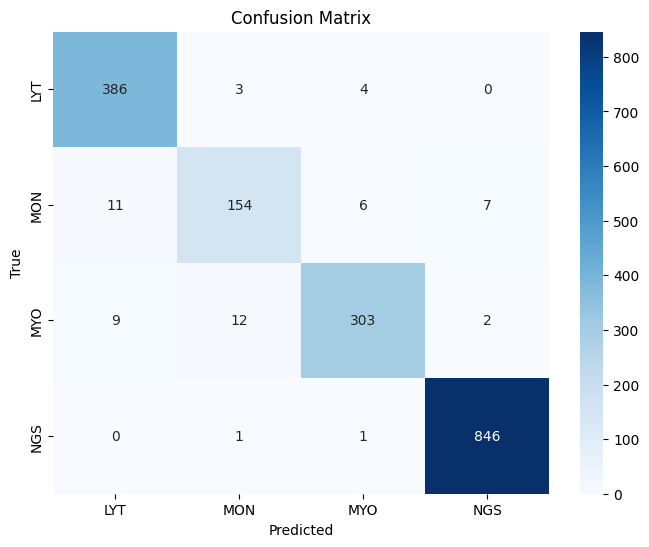

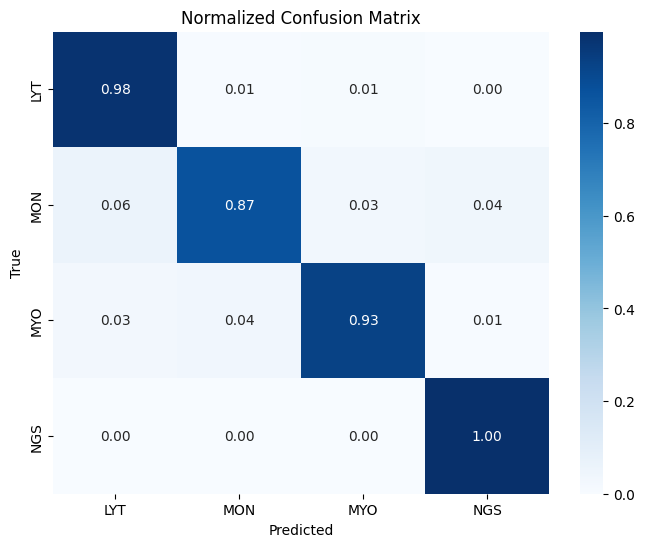

In [19]:
# 1) Crea un’istanza del modello, identico a quello usato in training
loaded_model = CustomModel(
    num_classes=full_dataset.num_classes,
    model_name="resnet18", 
    pretrained=False
).to(DEVICE)

# 2) Carica i pesi salvati
loaded_model.load_state_dict(torch.load("resnet18_best_fold4.pth"))

# 3) Metti il modello in eval mode
loaded_model.eval()

# 4) Valuta sul test set
test_loss, test_acc, p, r, f1, preds, labels = validate(
    loaded_model, 
    dl_test,      # il DataLoader del test
    criterion,    # ad esempio nn.CrossEntropyLoss()
    DEVICE
)

print("=== EVALUATION DEL MODELLO CARICATO ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)


=== EVALUATION DEL MODELLO CARICATO ===
Test Loss 0.0932, Test Acc 0.9713
Precision 0.97, Recall 0.97, F1 0.97


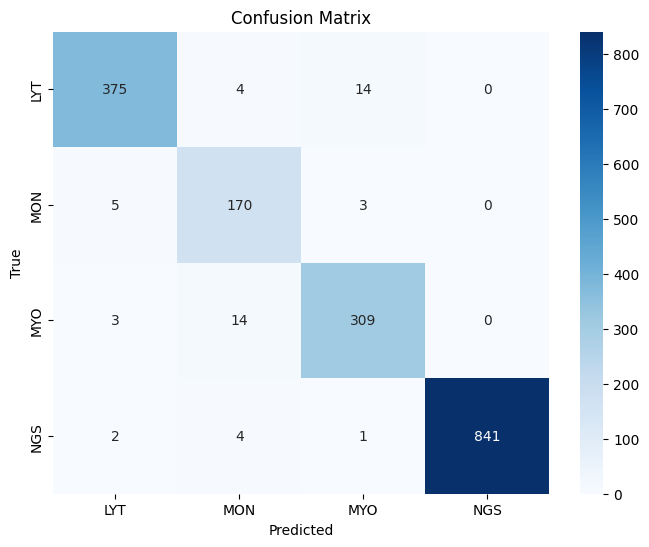

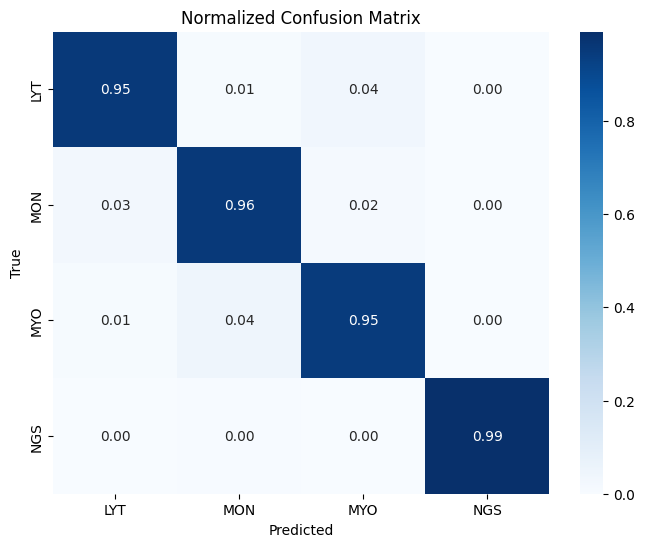

In [22]:
# 1) Crea un’istanza del modello, identico a quello usato in training
loaded_model = CustomModel(
    num_classes=full_dataset.num_classes,
    model_name="resnet18", 
    pretrained=False
).to(DEVICE)

# 2) Carica i pesi salvati
loaded_model.load_state_dict(torch.load("resnet18_best_fold1.pth"))

# 3) Metti il modello in eval mode
loaded_model.eval()

# 4) Valuta sul test set
test_loss, test_acc, p, r, f1, preds, labels = validate(
    loaded_model, 
    dl_test,      # il DataLoader del test
    criterion,    # ad esempio nn.CrossEntropyLoss()
    DEVICE
)

print("=== EVALUATION DEL MODELLO CARICATO ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)
